## 1. Постановка задачи

<center> <img src=https://storage.googleapis.com/kaggle-competitions/kaggle/3333/media/taxi_meter.png align="right" width="300"/> </center>
    
Вам предстоит решить настоящую задачу машинного обучения, направленную на автоматизацию бизнес процессов. Мы построим модель, которая будет предсказывать общую продолжительность поездки такси в Нью-Йорке.

Представьте вы заказываете такси из одной точки Нью-Йорка в другую, причем не обязательно конечная точка должна находиться в пределах города. Сколько вы должны будете за нее заплатить? Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда вы едете, в какое время суток вы совершаете вашу поездку, погодных условий и так далее.

Таким образом, если мы разработаем алгоритм, способный определять длительность поездки, мы сможем прогнозировать ее стоимость самым тривиальным образом, например, просто умножая стоимость на заданный тариф.
Сервисы такси хранят огромные объёмы информации о поездках, включая такие данные как конечная, начальная точка маршрута, дата поездки и ее длительность. Эти данные можно использовать для того, чтобы прогнозировать длительность поездки в автоматическом режиме с привлечением искусственного интеллекта.

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для вас как для специалиста в Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

Загрузить свое решение на платформу Kaggle, тем самым поучаствовав в настоящем Data Science соревновании.
Во время выполнения проекта вы отработаете навыки работы с несколькими источниками данных, генерации признаков, разведывательного анализа и визуализации данных, отбора признаков и, конечно же, построения моделей машинного обучения!


## 2. Знакомство с данными, базовый анализ и расширение данных

Начнём наше исследование со знакомства с предоставленными данными. А также подгрузим дополнительные источники данных и расширим наш исходный датасет.


Заранее импортируем модули, которые нам понадобятся для решения задачи:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats

from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn import cluster
from sklearn import feature_selection
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')

Прочитаем наш файл с исходными данными:

In [2]:
taxi_data = pd.read_csv("/kaggle/input/project/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()


Train data shape: (1458644, 11)


id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

Итак, у нас с вами есть данные о почти 1.5 миллионах поездок и 11 характеристиках, которые описывают каждую из поездок.

Мы условно разделили признаки нескольких групп. Каждой из групп мы в дальнейшем уделим отдельное внимание.

**Данные о клиенте и таксопарке:**
* id - уникальный идентификатор поездки
* vendor_id - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* pickup_datetime - дата и время, когда был включен счетчик поездки
* dropoff_datetime - дата и время, когда счетчик был отключен

**Географическая информация:**
* pickup_longitude -  долгота, на которой был включен счетчик
* pickup_latitude - широта, на которой был включен счетчик
* dropoff_longitude - долгота, на которой счетчик был отключен
* dropoff_latitude - широта, на которой счетчик был отключен

**Прочие признаки:**
* passenger_count - количество пассажиров в транспортном средстве (введенное водителем значение)
* store_and_fwd_flag - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* trip_duration - продолжительность поездки в секундах


Для начала мы проведем базовый анализ того, насколько данные готовы к дальнейшей предобработке и анализу.

### Задание 2.1
Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведите признак pickup_datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S').

Определите временные рамки (без учета времени), за которые представлены данные.

In [3]:
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
taxi_data['dropoff_datetime'] = pd.to_datetime(taxi_data['dropoff_datetime'],format='%Y-%m-%d %H:%M:%S')

In [4]:
taxi_data[['pickup_datetime','dropoff_datetime']].describe()

pickup_datetime     dropoff_datetime
count               1458644              1458644
unique              1380222              1380377
top     2016-03-04 08:07:34  2016-02-19 19:25:04
freq                      5                    5
first   2016-01-01 00:00:17  2016-01-01 00:03:31
last    2016-06-30 23:59:39  2016-07-01 23:02:03

### Задание 2.2
Посмотрим на пропуски.
Сколько пропущенных значений присутствует в данных (суммарно по всем столбцам таблицы)?

In [5]:
taxi_data.isnull().sum() # Посмотрим на пропуски в данных

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

### Задание 2.3
Посмотрим на статистические характеристики некоторых признаков.

а) Сколько уникальных таксопарков присутствует в данных?

б) Каково максимальное количество пассажиров?

в) Чему равна средняя и медианная длительность поездки? Ответ приведите в секундах и округлите до целого.

г) Чему равно минимальное и максимальное время поездки (в секундах)?


In [6]:
taxi_data['vendor_id'].unique()

array([2, 1])

In [7]:
taxi_data.describe()

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
count  1.458644e+06     1.458644e+06      1.458644e+06     1.458644e+06   
mean   1.534950e+00     1.664530e+00     -7.397349e+01     4.075092e+01   
std    4.987772e-01     1.314242e+00      7.090186e-02     3.288119e-02   
min    1.000000e+00     0.000000e+00     -1.219333e+02     3.435970e+01   
25%    1.000000e+00     1.000000e+00     -7.399187e+01     4.073735e+01   
50%    2.000000e+00     1.000000e+00     -7.398174e+01     4.075410e+01   
75%    2.000000e+00     2.000000e+00     -7.396733e+01     4.076836e+01   
max    2.000000e+00     9.000000e+00     -6.133553e+01     5.188108e+01   

       dropoff_longitude  dropoff_latitude  trip_duration  
count       1.458644e+06      1.458644e+06   1.458644e+06  
mean       -7.397342e+01      4.075180e+01   9.594923e+02  
std         7.064327e-02      3.589056e-02   5.237432e+03  
min        -1.219333e+02      3.218114e+01   1.000000e+00  
25%        -7.399133e+01      4.073588e+01   3.970000e+02  
50%        -7.397975e+01      4.075452e+01   6.620000e+02  
75%        -7.396301e+01      4.076981e+01   1.075000e+03  
max        -6.133553e+01      4.392103e+01   3.526282e+06

Займемся расширением исходного набора данных как с помощью внешних источников, так и с помощью манипуляций над имеющимися в данных признаками.


### Задание 2.4
Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:
* pickup_date - дата включения счетчика - начала поездки (без времени);
* pickup_hour - час дня включения счетчика;
* pickup_day_of_week - наименование дня недели, в который был включен счетчик.

а) Сколько поездок было совершено в субботу?

б) Сколько поездок в среднем совершается в день? Ответ округлите до целого

In [8]:
def add_datetime_features(df):
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.day_name()
    return df

In [9]:
taxi_data = add_datetime_features(taxi_data)
taxi_data.groupby('pickup_date')['pickup_datetime'].count().mean().round() # Среднее число поездок в день

8015.0

In [10]:
taxi_data[taxi_data['pickup_day_of_week'] == 'Saturday'].shape[0] # Сколько поездок совершено в субботу

220868

### Задание 2.5
Реализуйте функцию add_holiday_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о праздничных днях;

и возвращает обновленную таблицу с данными о поездках с добавленным в нее столбцом pickup_holiday - бинарным признаком того, начата ли поездка в праздничный день или нет (1 - да, 0 - нет).

Чему равна медианная длительность поездки на такси в праздничные дни? Ответ приведите в секундах, округлив до целого.


In [11]:
holiday_data = pd.read_csv('/kaggle/input/project/holiday_data.csv', sep=';')
holiday_data['date'] = pd.to_datetime(holiday_data['date'],format='%Y-%m-%d')
holiday_data

day       date                     holiday
0     Friday 2016-01-01               New Years Day
1     Monday 2016-01-18  Martin Luther King Jr. Day
2     Friday 2016-02-12          Lincoln's Birthday
3     Monday 2016-02-15             Presidents' Day
4     Sunday 2016-05-08                Mother's Day
5     Monday 2016-05-30                Memorial Day
6     Sunday 2016-06-19                Father's Day
7     Monday 2016-07-04            Independence Day
8     Monday 2016-09-05                   Labor Day
9     Monday 2016-10-10                Columbus Day
10    Friday 2016-11-11                Veterans Day
11  Thursday 2016-11-24                Thanksgiving
12    Monday 2016-12-26     Christmas Day (in lieu)
13   Tuesday 2016-11-08                Election Day

In [12]:
def add_holiday_features(df_taxi, df_holiday):
    df_holiday['date'] = pd.to_datetime(df_holiday['date'],format='%Y-%m-%d')
    df_taxi['pickup_date'] = pd.to_datetime(df_taxi['pickup_date'],format='%Y-%m-%d')
    df_merged = df_taxi.join(df_holiday.set_index('date'), on='pickup_date', how='left') #Объединим DataFrames
    df_merged = df_merged.rename(columns={"holiday": "pickup_holiday"}) # Переименуем столбец
    df_merged = df_merged.drop(['day'], axis=1) # Удалим столбец day
    df_merged["pickup_holiday"] = df_merged["pickup_holiday"].fillna(0) # Произведём замену NAN на 0 в столбце pickup_holiday
    df_merged["pickup_holiday"].loc[df_merged["pickup_holiday"] != 0] = 1 # Не нулевые значения заменим на 1

    return df_merged
taxi_data = add_holiday_features(taxi_data, holiday_data)
taxi_data

id  vendor_id     pickup_datetime    dropoff_datetime  \
0        id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1        id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2        id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3        id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4        id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   
...            ...        ...                 ...                 ...   
1458639  id2376096          2 2016-04-08 13:31:04 2016-04-08 13:44:02   
1458640  id1049543          1 2016-01-10 07:35:15 2016-01-10 07:46:10   
1458641  id2304944          2 2016-04-22 06:57:41 2016-04-22 07:10:25   
1458642  id2714485          1 2016-01-05 15:56:26 2016-01-05 16:02:39   
1458643  id1209952          1 2016-04-05 14:44:25 2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937   
1                      1        -73.980415        40.738564   
2                      1        -73.979027        40.763939   
3                      1        -74.010040        40.719971   
4                      1        -73.973053        40.793209   
...                  ...               ...              ...   
1458639                4        -73.982201        40.745522   
1458640                1        -74.000946        40.747379   
1458641                1        -73.959129        40.768799   
1458642                1        -73.982079        40.749062   
1458643                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
0               -73.964630         40.765602                  N   
1               -73.999481         40.731152                  N   
2               -74.005333         40.710087                  N   
3               -74.012268         40.706718                  N   
4               -73.972923         40.782520                  N   
...                    ...               ...                ...   
1458639         -73.994911         40.740170                  N   
1458640         -73.970184         40.796547                  N   
1458641         -74.004433         40.707371                  N   
1458642         -73.974632         40.757107                  N   
1458643         -73.972809         40.790585                  N   

         trip_duration pickup_date  pickup_hour pickup_day_of_week  \
0                  455  2016-03-14           17             Monday   
1                  663  2016-06-12            0             Sunday   
2                 2124  2016-01-19           11            Tuesday   
3                  429  2016-04-06           19          Wednesday   
4                  435  2016-03-26           13           Saturday   
...                ...         ...          ...                ...   
1458639            778  2016-04-08           13             Friday   
1458640            655  2016-01-10            7             Sunday   
1458641            764  2016-04-22            6             Friday   
1458642            373  2016-01-05           15            Tuesday   
1458643            198  2016-04-05           14            Tuesday   

        pickup_holiday  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
1458639              0  
1458640              0  
1458641              0  
1458642              0  
1458643              0  

[1458644 rows x 15 columns]

In [13]:
taxi_data[taxi_data['pickup_holiday']==1]['trip_duration'].median()

585.0

### Задание 2.6
Реализуйте функцию add_osrm_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными из OSRM;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 3 столбцами:
* total_distance;
* total_travel_time;
* number_of_steps.

а) Чему равна разница (в секундах) между медианной длительностью поездки в данных и медианной длительностью поездки, полученной из OSRM?

В результате объединения таблиц у вас должны были получиться пропуски в столбцах с информацией из OSRM API. Это связано с тем, что для некоторых поездок не удалось выгрузить данные из веб источника.

б) Сколько пропусков содержится в столбцах с информацией из OSRM API после объединения таблиц?

In [14]:
osrm_data = pd.read_csv('/kaggle/input/project/osrm_data_train.csv')
osrm_data.shape

(1458643, 12)

In [15]:
def add_osrm_features(df_taxi, df_osrm):
    geo_df = df_taxi.join(df_osrm.set_index('id')[['total_distance', 'total_travel_time', 'number_of_steps']], on='id', how='left') #Объединим DataFrames
    return geo_df
taxi_data = add_osrm_features(taxi_data, osrm_data)
taxi_data

id  vendor_id     pickup_datetime    dropoff_datetime  \
0        id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1        id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2        id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3        id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4        id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   
...            ...        ...                 ...                 ...   
1458639  id2376096          2 2016-04-08 13:31:04 2016-04-08 13:44:02   
1458640  id1049543          1 2016-01-10 07:35:15 2016-01-10 07:46:10   
1458641  id2304944          2 2016-04-22 06:57:41 2016-04-22 07:10:25   
1458642  id2714485          1 2016-01-05 15:56:26 2016-01-05 16:02:39   
1458643  id1209952          1 2016-04-05 14:44:25 2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937   
1                      1        -73.980415        40.738564   
2                      1        -73.979027        40.763939   
3                      1        -74.010040        40.719971   
4                      1        -73.973053        40.793209   
...                  ...               ...              ...   
1458639                4        -73.982201        40.745522   
1458640                1        -74.000946        40.747379   
1458641                1        -73.959129        40.768799   
1458642                1        -73.982079        40.749062   
1458643                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  \
0               -73.964630         40.765602                  N   
1               -73.999481         40.731152                  N   
2               -74.005333         40.710087                  N   
3               -74.012268         40.706718                  N   
4               -73.972923         40.782520                  N   
...                    ...               ...                ...   
1458639         -73.994911         40.740170                  N   
1458640         -73.970184         40.796547                  N   
1458641         -74.004433         40.707371                  N   
1458642         -73.974632         40.757107                  N   
1458643         -73.972809         40.790585                  N   

         trip_duration pickup_date  pickup_hour pickup_day_of_week  \
0                  455  2016-03-14           17             Monday   
1                  663  2016-06-12            0             Sunday   
2                 2124  2016-01-19           11            Tuesday   
3                  429  2016-04-06           19          Wednesday   
4                  435  2016-03-26           13           Saturday   
...                ...         ...          ...                ...   
1458639            778  2016-04-08           13             Friday   
1458640            655  2016-01-10            7             Sunday   
1458641            764  2016-04-22            6             Friday   
1458642            373  2016-01-05           15            Tuesday   
1458643            198  2016-04-05           14            Tuesday   

        pickup_holiday  total_distance  total_travel_time  number_of_steps  
0                    0          2009.1              164.9              5.0  
1                    0          2513.2              332.0              6.0  
2                    0         11060.8              767.6             16.0  
3                    0          1779.4              235.8              4.0  
4                    0          1614.9              140.1              5.0  
...                ...             ...                ...              ...  
1458639              0          2234.6              311.7              8.0  
1458640              0          7638.0              589.6             11.0  
1458641              0          9871.5     

In [16]:
taxi_data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        1
total_travel_time     1
number_of_steps       1
dtype: int64

In [17]:
def get_haversine_distance(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # радиус земли в километрах
    EARTH_RADIUS = 6371
    # считаем кратчайшее расстояние h по формуле Хаверсина
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    # переводим углы в радианы
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # считаем угол направления движения alpha по формуле угла пеленга
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

### Задание 2.7.
Реализуйте функцию add_geographical_features(), которая принимает на вход таблицу с данными о поездках и возвращает обновленную таблицу с добавленными в нее 2 столбцами:
* haversine_distance - расстояние Хаверсина между точкой, в которой был включен счетчик, и точкой, в которой счетчик был выключен;
* direction - направление движения из точки, в которой был включен счетчик, в точку, в которой счетчик был выключен.

Чему равно медианное расстояние Хаверсина поездок (в киллометрах)? Ответ округлите до сотых.


In [18]:
def add_geographical_features(df):
  df['haversine_distance'] = get_haversine_distance(df['pickup_latitude'],df['pickup_longitude'],df['dropoff_latitude'],df['dropoff_longitude'])
  df['direction'] = get_angle_direction(df['pickup_latitude'],df['pickup_longitude'],df['dropoff_latitude'],df['dropoff_longitude'])
  return df
taxi_data = add_geographical_features(taxi_data)
taxi_data['haversine_distance'].median()

2.0937171329263693

### Задание 2.8.
Реализуйте функцию add_cluster_features(), которая принимает на вход таблицу с данными о поездках и обученный алгоритм кластеризации. Функция должна возвращать обновленную таблицу с добавленными в нее столбцом geo_cluster - географический кластер, к которому относится поездка.

Сколько поездок содержится в наименьшем по размеру географическом кластере?


In [78]:
def add_cluster_features(df_taxi):
    coords = np.hstack((df_taxi[['pickup_latitude', 'pickup_longitude']],
                    df_taxi[['dropoff_latitude', 'dropoff_longitude']]))
    kmeans = cluster.KMeans(n_clusters=10, random_state=42)
    kmeans.fit(coords)
    df_taxi['geo_cluster'] = kmeans.predict(coords)
    return df_taxi
taxi_data = add_cluster_features(taxi_data, kmeans)

In [20]:
taxi_data['geo_cluster'].value_counts().min()

2

### Задание 2.9.
Реализуйте функцию add_weather_features(), которая принимает на вход две таблицы:
* таблицу с данными о поездках;
* таблицу с данными о погодных условиях на каждый час;

и возвращает обновленную таблицу с данными о поездках с добавленными в нее 5 столбцами:
* temperature - температура;
* visibility - видимость;
* wind speed - средняя скорость ветра;
* precip - количество осадков;
* events - погодные явления.

а) Сколько поездок было совершено в снежную погоду?

В результате объединения у вас должны получиться записи, для которых в столбцах temperature, visibility, wind speed, precip, и events будут пропуски. Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, в которых включался счетчик поездки.

б) Сколько процентов от общего количества наблюдений в таблице с данными о поездках занимают пропуски в столбцах с погодными условиями? Ответ приведите с точностью до сотых процента.


In [21]:
weather_data = pd.read_csv('/kaggle/input/project/weather_data.csv')
weather_data.head()


time  temperature  windchill  heat index  humidity  \
0  2015-12-31 02:00:00          7.8        7.1         NaN      0.89   
1  2015-12-31 03:00:00          7.2        5.9         NaN      0.90   
2  2015-12-31 04:00:00          7.2        NaN         NaN      0.90   
3  2015-12-31 05:00:00          7.2        5.9         NaN      0.86   
4  2015-12-31 06:00:00          7.2        6.4         NaN      0.90   

   pressure  dew Point  visibility  wind dir  wind speed  gust speed  precip  \
0    1017.0        6.1         8.0       NNE         5.6         0.0     0.8   
1    1016.5        5.6        12.9  Variable         7.4         0.0     0.3   
2    1016.7        5.6        12.9      Calm         0.0         0.0     0.0   
3    1015.9        5.0        14.5        NW         7.4         0.0     0.0   
4    1016.2        5.6        11.3      West         5.6         0.0     0.0   

  events conditions        date  hour  
0   None   Overcast  2015-12-31     2  
1   None   Overcast  2015-12-31     3  
2   None   Overcast  2015-12-31     4  
3   None   Overcast  2015-12-31     5  
4   None   Overcast  2015-12-31     6

In [22]:
def add_weather_features(df_taxi, df_weather):
    df_weather['time'] = pd.to_datetime(df_weather['time'])
    df_weather['date'] = pd.to_datetime(df_weather['date'])
    df_weather['hour'] = df_weather['time'].dt.hour

    weather_columns = [
        'date', 'hour', 'temperature', 'visibility',
        'wind speed', 'precip', 'events'
    ]

    df_taxi = df_taxi.merge(
        df_weather[weather_columns],
        left_on=['pickup_date', 'pickup_hour'],
        right_on=['date', 'hour'],
        how='left'
    )
    df_taxi = df_taxi.drop(['date', 'hour'], axis=1)
    return df_taxi

In [23]:
taxi_data_weather = add_weather_features(taxi_data, weather_data)
taxi_data_weather

id  vendor_id     pickup_datetime    dropoff_datetime  \
0        id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1        id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2        id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3        id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4        id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   
...            ...        ...                 ...                 ...   
1458639  id2376096          2 2016-04-08 13:31:04 2016-04-08 13:44:02   
1458640  id1049543          1 2016-01-10 07:35:15 2016-01-10 07:46:10   
1458641  id2304944          2 2016-04-22 06:57:41 2016-04-22 07:10:25   
1458642  id2714485          1 2016-01-05 15:56:26 2016-01-05 16:02:39   
1458643  id1209952          1 2016-04-05 14:44:25 2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937   
1                      1        -73.980415        40.738564   
2                      1        -73.979027        40.763939   
3                      1        -74.010040        40.719971   
4                      1        -73.973053        40.793209   
...                  ...               ...              ...   
1458639                4        -73.982201        40.745522   
1458640                1        -74.000946        40.747379   
1458641                1        -73.959129        40.768799   
1458642                1        -73.982079        40.749062   
1458643                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  ...  \
0               -73.964630         40.765602                  N  ...   
1               -73.999481         40.731152                  N  ...   
2               -74.005333         40.710087                  N  ...   
3               -74.012268         40.706718                  N  ...   
4               -73.972923         40.782520                  N  ...   
...                    ...               ...                ...  ...   
1458639         -73.994911         40.740170                  N  ...   
1458640         -73.970184         40.796547                  N  ...   
1458641         -74.004433         40.707371                  N  ...   
1458642         -73.974632         40.757107                  N  ...   
1458643         -73.972809         40.790585                  N  ...   

         total_travel_time number_of_steps  haversine_distance   direction  \
0                    164.9             5.0            1.498521   99.970196   
1                    332.0             6.0            1.805507 -117.153768   
2                    767.6            16.0            6.385098 -159.680165   
3                    235.8             4.0            1.485498 -172.737700   
4                    140.1             5.0            1.188588  179.473585   
...                    ...             ...                 ...         ...   
1458639              311.7             8.0            1.225080 -119.059338   
1458640              589.6            11.0            6.049836   25.342196   
1458641              642.9            10.0            7.824606 -150.788492   
1458642              161.6             7.0            1.092564   35.033294   
1458643               90.7             2.0            1.134042   29.969486   

        geo_cluster  temperature  visibility  wind speed  precip  events  
0                 9          4.4         8.0        27.8     0.3    None  
1                 4         28.9        16.1         7.4     0.0    None  
2                 4         -6.7        16.1        24.1     0.0    None  
3                 4          7.2        16.1        25.9     0.0    None  
4                 9          9.4        16.1         9.3     0.0    None  
...             ...          ...         ...         ...     ...     ...  
1458639           0          7.8        16.1        11.

### Задание 2.10.
Реализуйте функцию fill_null_weather_data(), которая принимает на вход которая принимает на вход таблицу с данными о поездках. Функция должна заполнять пропущенные значения в столбцах.

Пропуски в столбцах с погодными условиями -  temperature, visibility, wind speed, precip заполните медианным значением температуры, влажности, скорости ветра и видимости в зависимости от даты начала поездки. Для этого сгруппируйте данные по столбцу pickup_date и рассчитайте медиану в каждой группе, после чего с помощью комбинации методов transform() и fillna() заполните пропуски.
Пропуски в столбце events заполните строкой 'None' - символом отсутствия погодных явлений (снега/дождя/тумана).

Пропуски в столбцах с информацией из OSRM API - total_distance, total_travel_time и number_of_steps заполните медианным значением по столбцам.

Чему равна медиана в столбце temperature после заполнения пропусков? Ответ округлите до десятых.


In [24]:
def fill_null_weather_data(df_taxi):
    col = ['temperature', 'visibility', 'wind speed', 'precip']
    df_taxi[col] = df_taxi[col].fillna(df_taxi.groupby('pickup_date')[col].transform('median'))
    df_taxi['events'] = df_taxi['events'].fillna('None')
    col_osrm = ['total_distance', 'total_travel_time', 'number_of_steps']
    for osrm in col_osrm:
      df_taxi[osrm] = df_taxi[osrm].fillna(df_taxi[osrm].median(skipna=True))
    return df_taxi
taxi_fill = fill_null_weather_data(taxi_data_weather)
temp = taxi_fill['temperature'].median()
print(f'медианная температура в столбце temperature равна {temp} градусов')

медианная температура в столбце temperature равна 11.1 градусов


In [25]:
taxi_fill.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
pickup_hour           0
pickup_day_of_week    0
pickup_holiday        0
total_distance        0
total_travel_time     0
number_of_steps       0
haversine_distance    0
direction             0
geo_cluster           0
temperature           0
visibility            0
wind speed            0
precip                0
events                0
dtype: int64

В завершение первой части найдем очевидные выбросы в целевой переменной - длительности поездки.

Проще всего найти слишком продолжительные поездки. Давайте условимся, что выбросами будут считаться поездки, длительность которых превышает 24 часа.

Чуть сложнее с анализом поездок, длительность которых слишком мала. Потому что к ним относятся действительно реальные поездки на короткие расстояния, поездки, которые были отменены через секунду после того как включился счетчик, а также “телепортации” - перемещение на большие расстояния за считанные секунды.
Условимся, что мы будем считать выбросами только последнюю группу. Как же нам их обнаружить наиболее простым способом?

Можно воспользоваться информацией о кратчайшем расстоянии, которое проезжает такси. Вычислить среднюю скорость автомобиля на кратчайшем пути следующим образом:
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$
Если мы построим диаграмму рассеяния средней скорости движения автомобилей, мы увидим следующую картину:


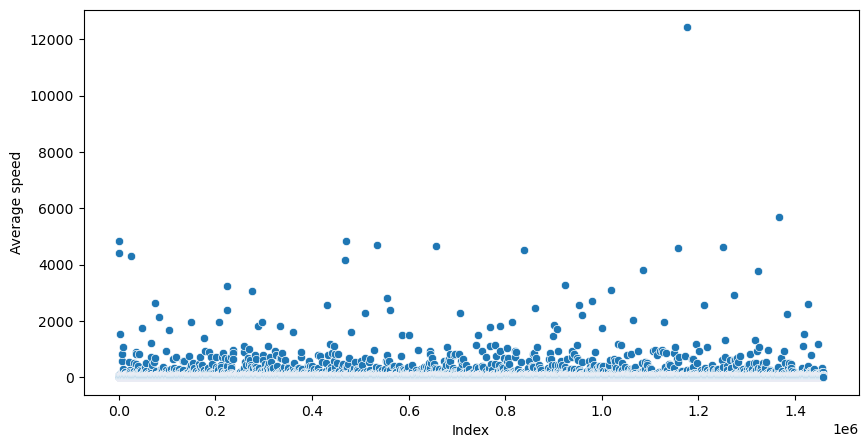

In [26]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

Как раз отсюда мы видим, что у нас есть “поездки-телепортации”, для которых средняя скорость более 1000 км/ч. Даже есть такая, средняя скорость которой составляла более 12000 км/ч!

Давайте условимся, что предельная средняя скорость, которую могут развивать таксисты будет 300 км/ч.


### Задание 2.11.
Найдите поездки, длительность которых превышает 24 часа. И удалите их из набора данных.

а) Сколько выбросов по признаку длительности поездки вам удалось найти?

Найдите поездки, средняя скорость которых по кратчайшему пути превышает 300 км/ч и удалите их из данных.

б) Сколько выбросов по признаку скорости вам удалось найти?

In [27]:
trip_d = taxi_fill[(taxi_fill['trip_duration']>86400)]
print(f'количество выбросов по признаку длительности поездки: {trip_d.shape[0]}')

количество выбросов по признаку длительности поездки: 4


In [28]:
avg_speed = taxi_fill[((taxi_fill['total_distance'] / taxi_fill['trip_duration'] * 3.6) >=300)]
print(f'количество выбросов по признаку скорости: {avg_speed.shape[0]}')

количество выбросов по признаку скорости: 407


In [29]:
taxi_fill = taxi_fill.drop(trip_d.index, axis=0)
taxi_fill = taxi_fill.drop(avg_speed.index, axis=0)

## 3. Разведывательный анализ данных (EDA)

В этой части нашего проекта мы с вами:
* Исследуем сформированный набор данных;
* Попробуем найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими в определении длительности поездки;
* Дополним наш анализ визуализациями, иллюстрирующими; исследование. Постарайтесь оформлять диаграммы с душой, а не «для галочки»: навыки визуализации полученных выводов обязательно пригодятся вам в будущем.


Начинаем с целевого признака. Забегая вперед, скажем, что основной метрикой качества решения поставленной задачи будет RMSLE - Root Mean Squared Log Error, которая вычисляется на основе целевой переменной в логарифмическом масштабе. В таком случае целесообразно сразу логарифмировать признак длительности поездки и рассматривать при анализе логарифм в качестве целевого признака:
$$trip\_duration\_log = log(trip\_duration+1),$$
где под символом log подразумевается натуральный логарифм.


In [30]:
taxi_fill['trip_duration_log'] = np.log(taxi_fill['trip_duration']+1)

### Задание 3.1.
Постройте гистограмму и коробчатую диаграмму длительности поездок в логарифмическом масштабе (trip_duration_log).
Исходя из визуализации, сделайте предположение, является ли полученное распределение нормальным?
Проверьте свою гипотезу с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$.

а) Чему равен вычисленный p-value? Ответ округлите до сотых.

б) Является ли распределение длительности поездок в логарифмическом масштабе нормальным?

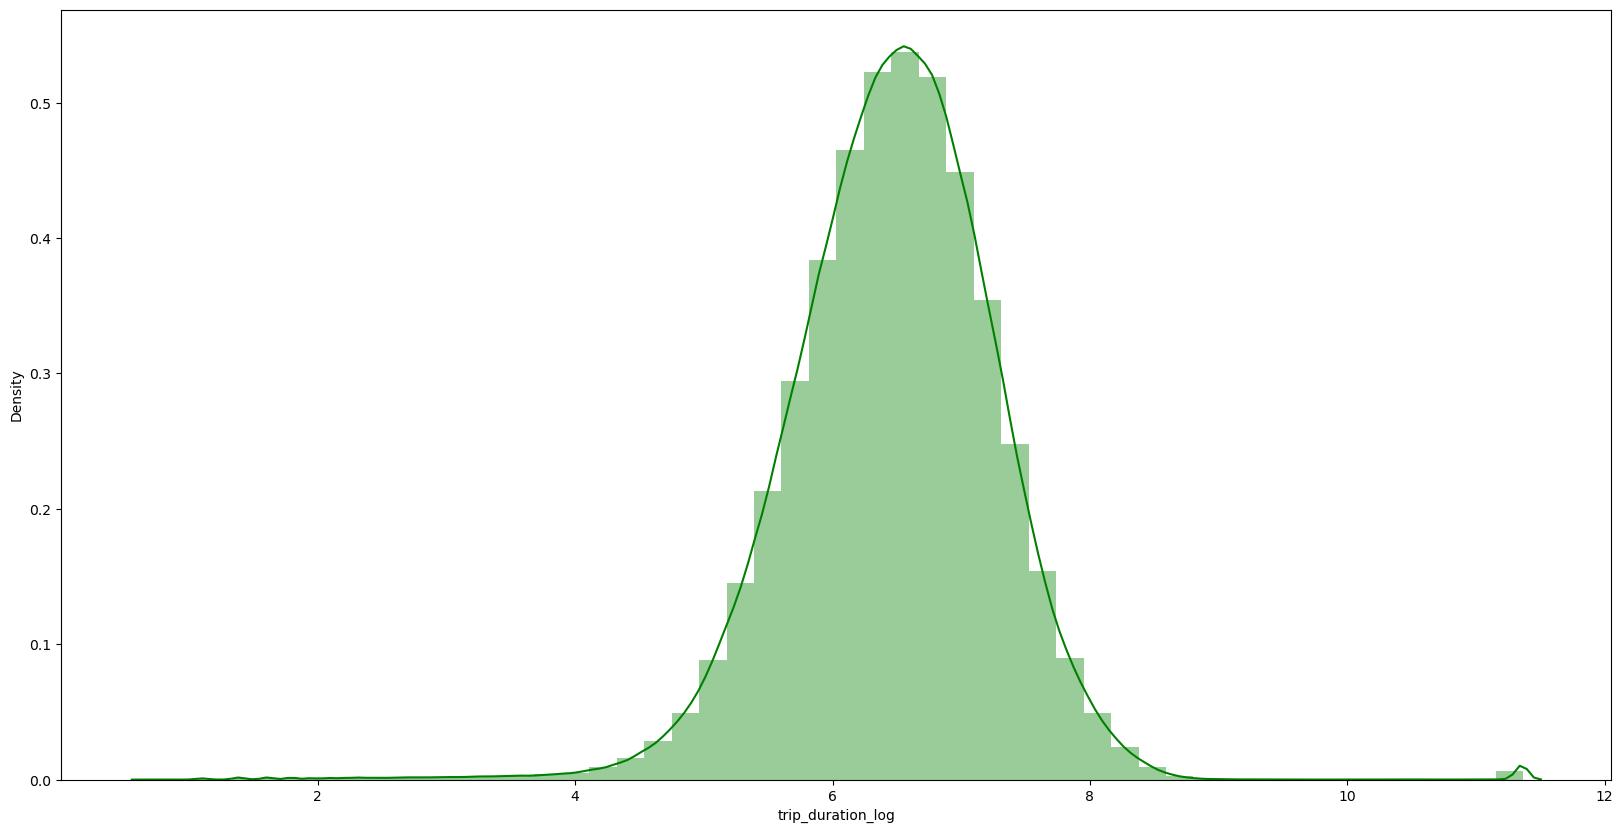

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))
sns_plot = sns.distplot(taxi_fill['trip_duration_log'], color='green')
fig = sns_plot.get_figure()

In [32]:
stat, p = stats.normaltest(taxi_fill['trip_duration_log'])
p

0.0

### Задание 3.2.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от таксопарка (vendor_id).

Сравните два распределения между собой.

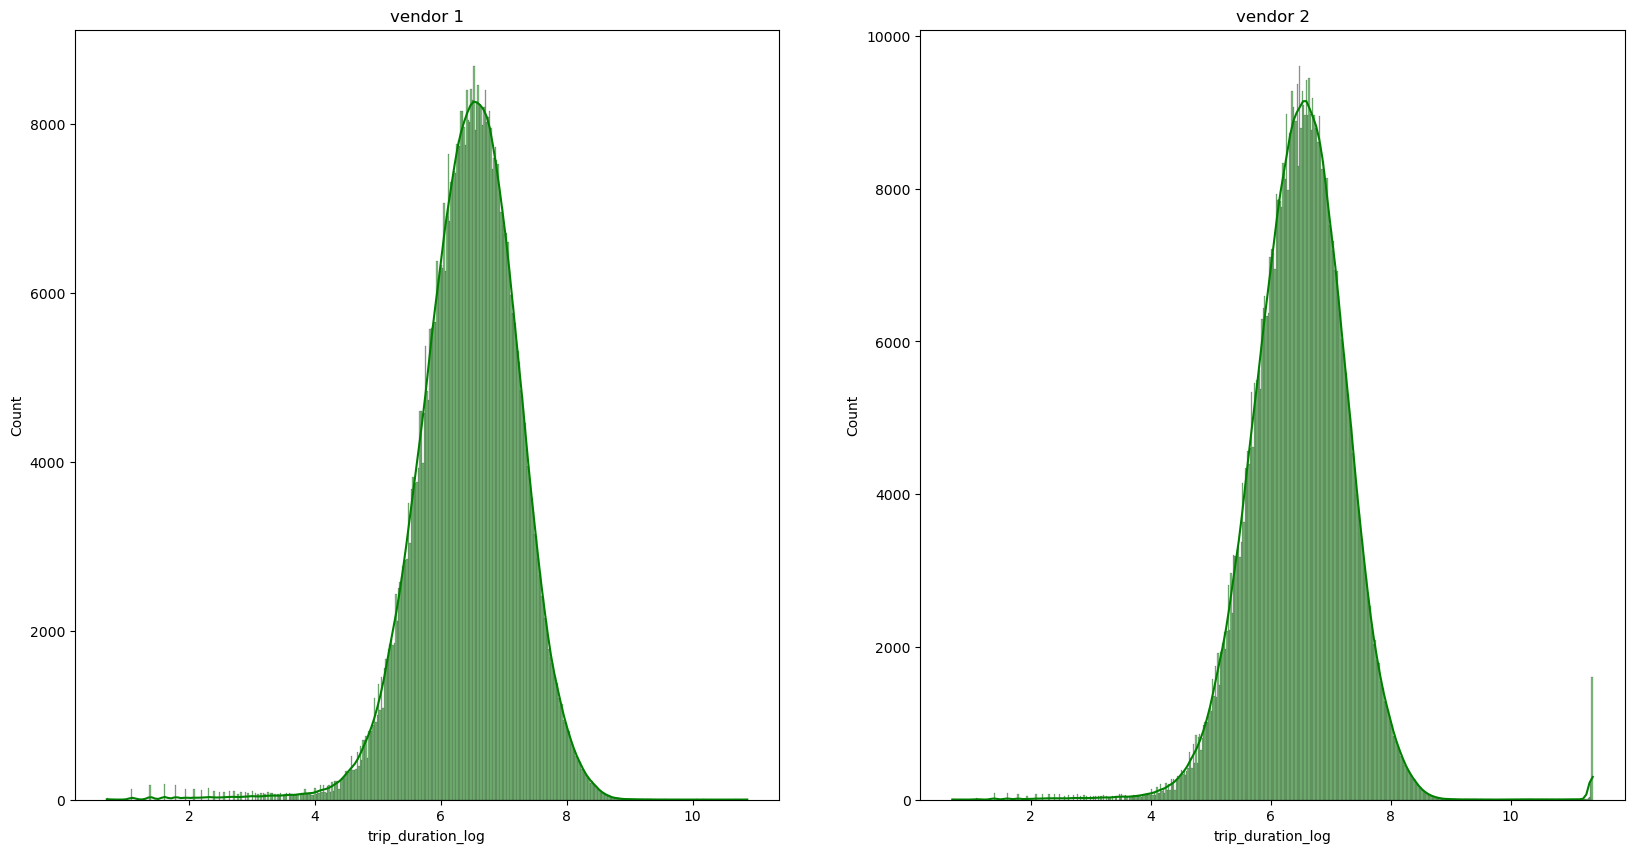

In [33]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
histplot = sns.histplot(data=taxi_fill[taxi_fill['vendor_id'] == 1]['trip_duration_log'],color='green', ax=axes[0], kde=True);
histplot.set_title('vendor 1');
histplot = sns.histplot(data=taxi_fill[taxi_fill['vendor_id'] == 2]['trip_duration_log'],color='green', ax=axes[1], kde=True);
histplot.set_title('vendor 2');

Распределения в группах практически не отличаются, признак vendor_id не имеет значения при определении длительности поездки.

### Задание 3.3.
Постройте визуализацию, которая позволит сравнить распределение длительности поездки в логарифмическом масштабе (trip_duration_log) в зависимости от признака отправки сообщения поставщику (store_and_fwd_flag).

Сравните два распределения между собой.

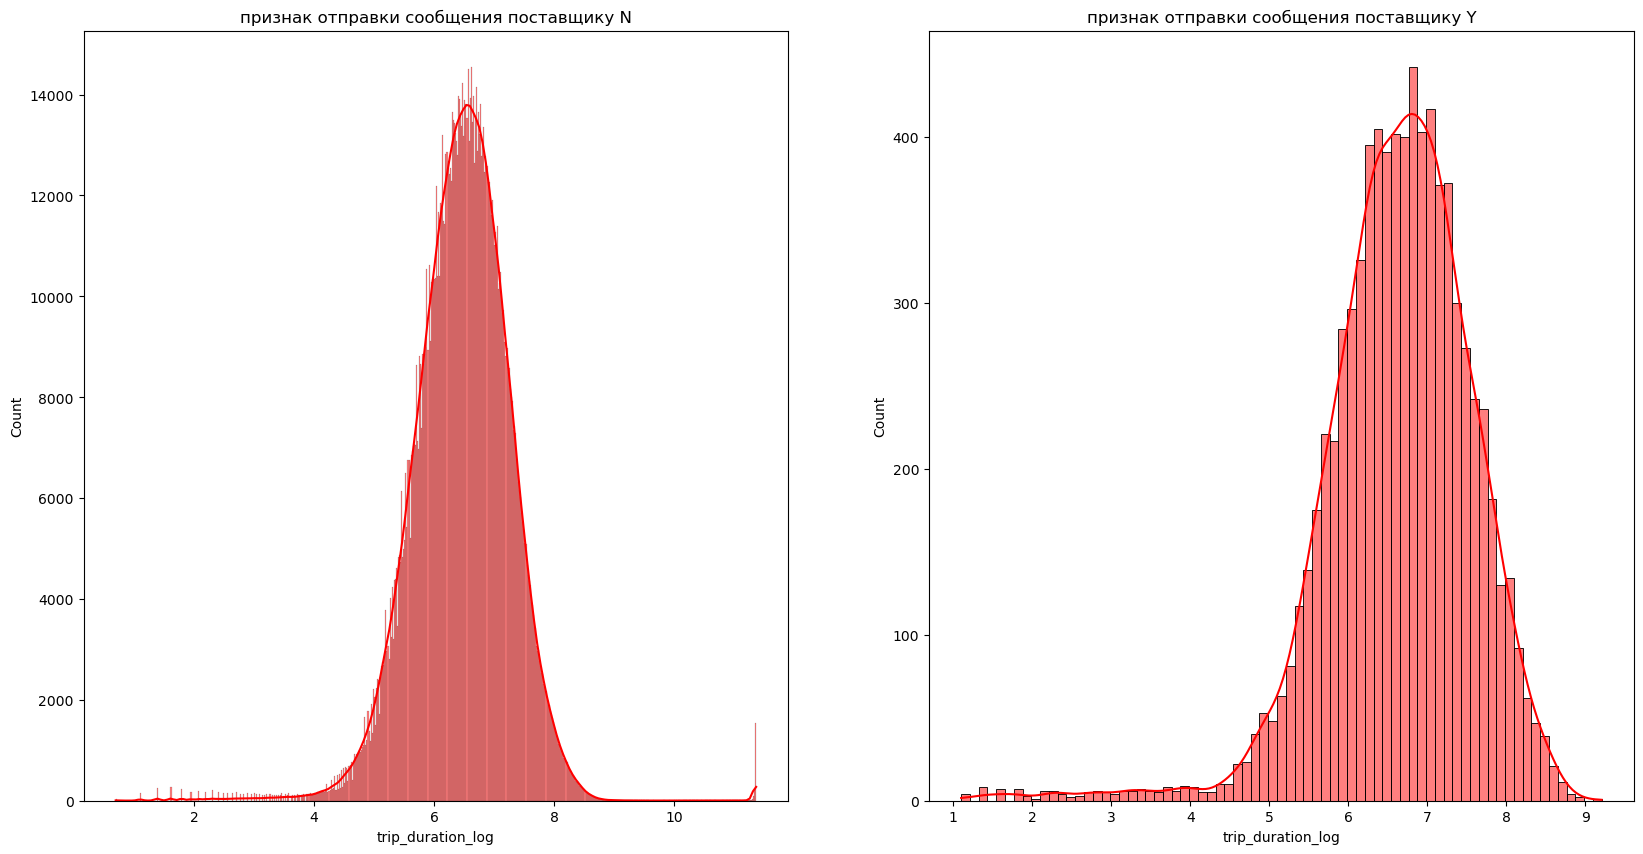

In [34]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
histplot = sns.histplot(data=taxi_fill[taxi_fill['store_and_fwd_flag'] == 'N']['trip_duration_log'],color='red', ax=axes[0], kde=True);
histplot.set_title('признак отправки сообщения поставщику N');
histplot = sns.histplot(data=taxi_fill[taxi_fill['store_and_fwd_flag'] == 'Y']['trip_duration_log'],color='red', ax=axes[1], kde=True);
histplot.set_title('признак отправки сообщения поставщику Y');

Распределения в группах значительно отличаются, признак store_and_fwd_flag имеет значение при определении длительности поездки.

### Задание 3.4.
Постройте две визуализации:
* Распределение количества поездок в зависимости от часа дня;
* Зависимость медианной длительности поездки от часа дня.

На основе построенных графиков ответьте на следующие вопросы:

а) В какое время суток такси заказывают реже всего?

б) В какое время суток наблюдается пик медианной длительности поездок?

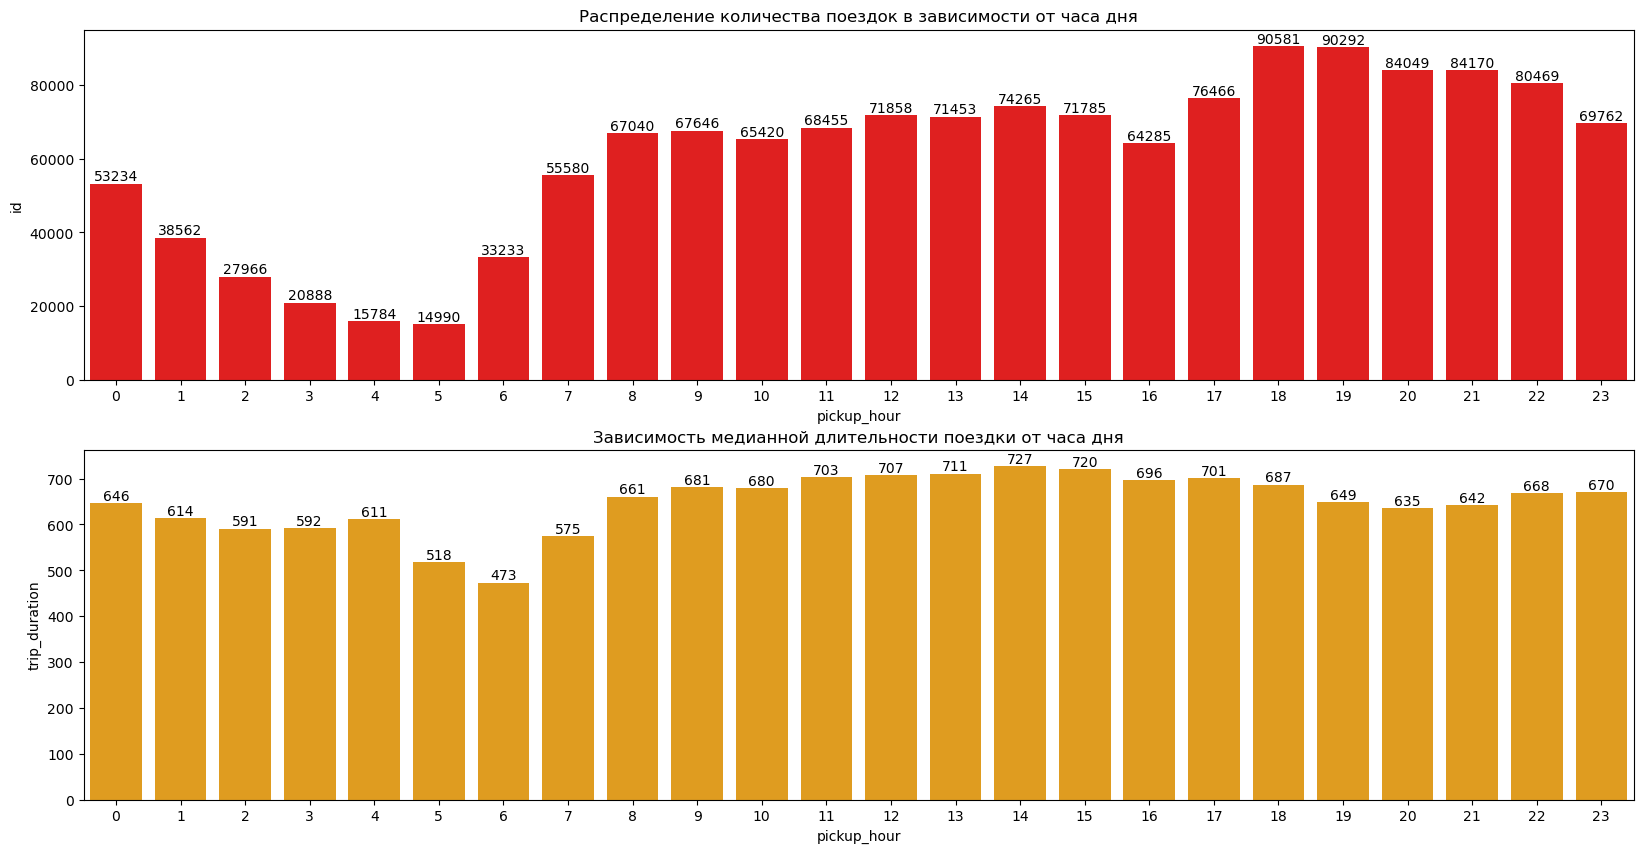

In [35]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))


data1 = taxi_fill.groupby(by='pickup_hour', as_index=False).count();
data2 = taxi_fill.groupby(by='pickup_hour', as_index=False)['trip_duration'].median();
barplot = sns.barplot(
    data=data1,
    x=data1.iloc[:, 0],
    y=data1.iloc[:, 1],
    color='red',
    ax=axes[0]);
barplot.set_title('Распределение количества поездок в зависимости от часа дня');
barplot.bar_label(barplot.containers[0]);
barplot = sns.barplot(
    data=data2,
    x=data2.iloc[:, 0],
    y=data2.iloc[:, 1],
    color='orange',
    ax=axes[1]);
barplot.set_title('Зависимость медианной длительности поездки от часа дня');
barplot.bar_label(barplot.containers[0]);

Пик медианной длительности поездки приходится с 13:00 по 18:00

Реже всего такси заказывают в ночное время

### Задание 3.5.
Постройте две визуализации:
* Распределение количества поездок в зависимости от дня недели;
*  Зависимость медианной длительности поездки от дня недели.

На основе построенных графиков ответьте на следующие вопросы:
а) В какой день недели совершается больше всего поездок?
б) В какой день недели медианная длительность поездок наименьшая?


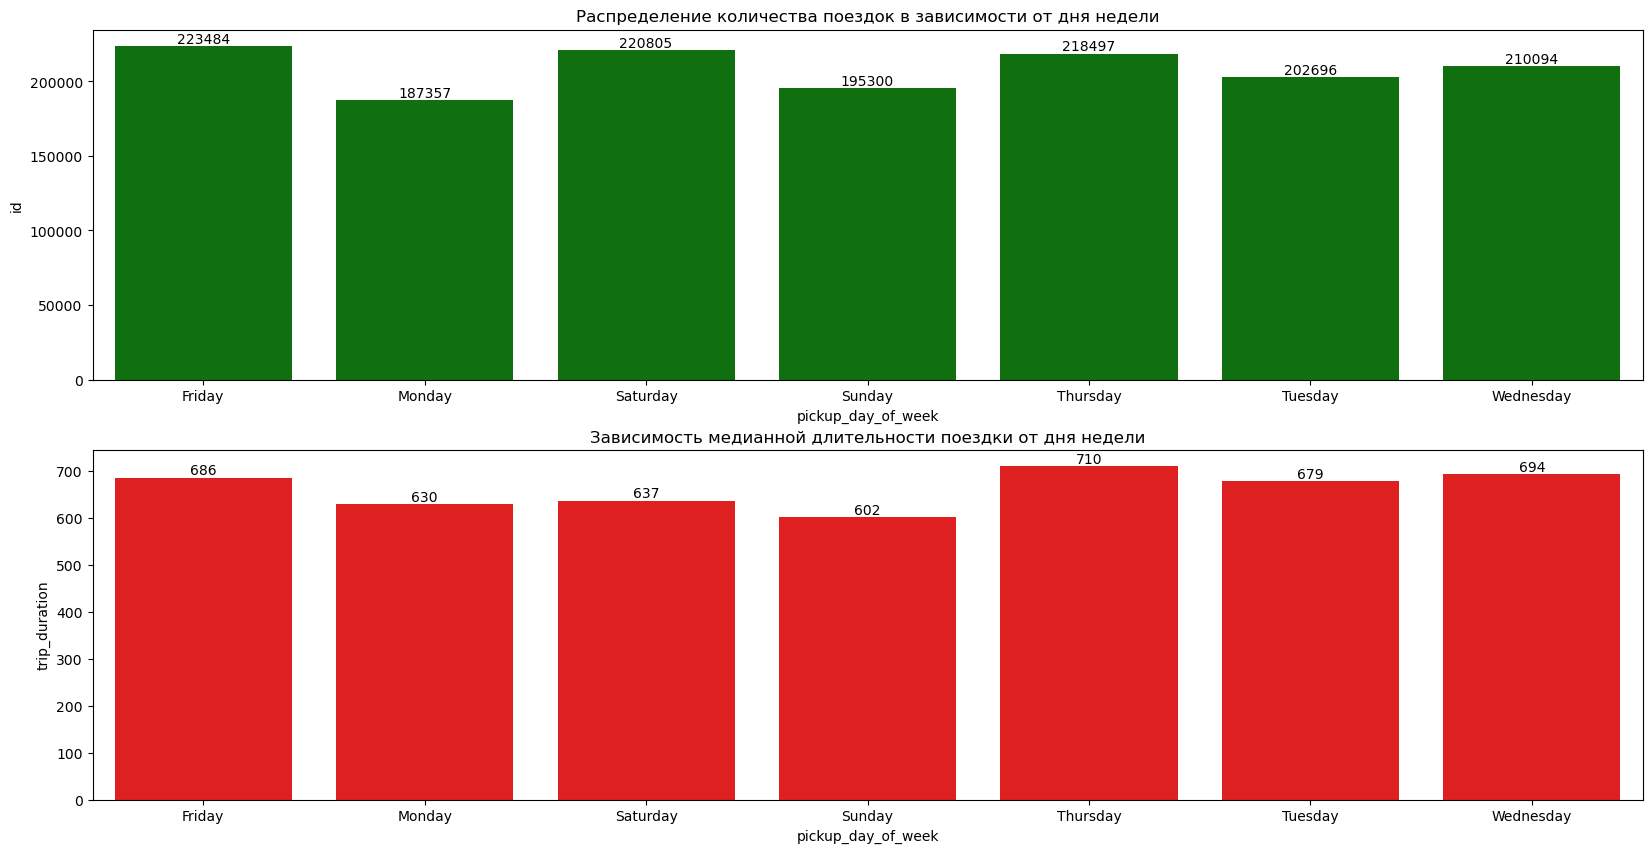

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))

data1 = taxi_fill.groupby(by='pickup_day_of_week', as_index=False).count()
data2 = taxi_fill.groupby(by='pickup_day_of_week', as_index=False)['trip_duration'].median()
barplot = sns.barplot(
    data=data1,
    x=data1.iloc[:, 0],
    y=data1.iloc[:, 1],
    color='green',
    ax=axes[0])
barplot.set_title('Распределение количества поездок в зависимости от дня недели');
barplot.bar_label(barplot.containers[0]);
barplot = sns.barplot(
    data=data2,
    x=data2.iloc[:, 0],
    y=data2.iloc[:, 1],
    color='red',
    ax=axes[1]);
barplot.set_title('Зависимость медианной длительности поездки от дня недели');
barplot.bar_label(barplot.containers[0]);

### Задание 3.6.
Посмотрим на обе временные характеристики одновременно.

Постройте сводную таблицу, по строкам которой отложены часы (pickup_hour), по столбцам - дни недели (pickup_day_of_week), а в ячейках - медианная длительность поездки (trip_duration).

Визуализируйте полученную сводную таблицу с помощью тепловой карты (рекомендуемая палитра - coolwarm).

In [37]:

trip=taxi_fill.pivot_table(
    values='trip_duration',
    index='pickup_hour',
    columns='pickup_day_of_week',
    fill_value=0,
    aggfunc='median'
)
trip

pickup_day_of_week  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  \
pickup_hour                                                               
0                    649.0     598     685.0   675.0       609    591.0   
1                    600.0     567     640.0   643.0       564    584.0   
2                    572.0     565     610.0   604.5       576    565.0   
3                    578.0     600     591.0   608.0       584    568.0   
4                    634.0     640     610.0   598.5       595    600.5   
5                    532.0     519     631.0   634.0       480    455.0   
6                    476.0     462     508.0   554.0       471    461.0   
7                    578.0     575     481.0   474.0       599    586.0   
8                    689.0     672     489.0   460.0       721    703.0   
9                    743.0     705     510.0   470.0       772    755.0   
10                   744.0     694     542.0   506.0       772    778.0   
11                   754.5     702     579.0   551.0       804    806.0   
12                   746.0     692     618.0   594.0       799    783.5   
13                   712.0     673     651.5   628.0       772    768.5   
14                   735.0     681     660.0   667.0       811    768.0   
15                   759.0     676     662.0   658.5       786    741.0   
16                   729.5     642     655.0   672.0       757    706.0   
17                   712.0     645     685.0   650.0       753    713.0   
18                   696.0     637     678.0   641.0       729    699.5   
19                   669.0     575     698.0   600.5       692    631.0   
20                   664.0     573     669.0   585.0       682    622.0   
21                   666.0     597     656.0   570.0       692    634.0   
22                   705.0     602     690.0   586.0       709    659.0   
23                   717.0     612     705.0   595.5       692    633.0   

pickup_day_of_week  Wednesday  
pickup_hour                    
0                       601.0  
1                       553.0  
2                       544.0  
3                       574.0  
4                       616.0  
5                       448.0  
6                       463.0  
7                       593.0  
8                       704.0  
9                       742.0  
10                      788.0  
11                      809.0  
12                      800.5  
13                      798.0  
14                      783.0  
15                      774.0  
16                      741.0  
17                      759.0  
18                      724.0  
19                      658.0  
20                      639.0  
21                      665.0  
22                      675.0  
23                      659.0

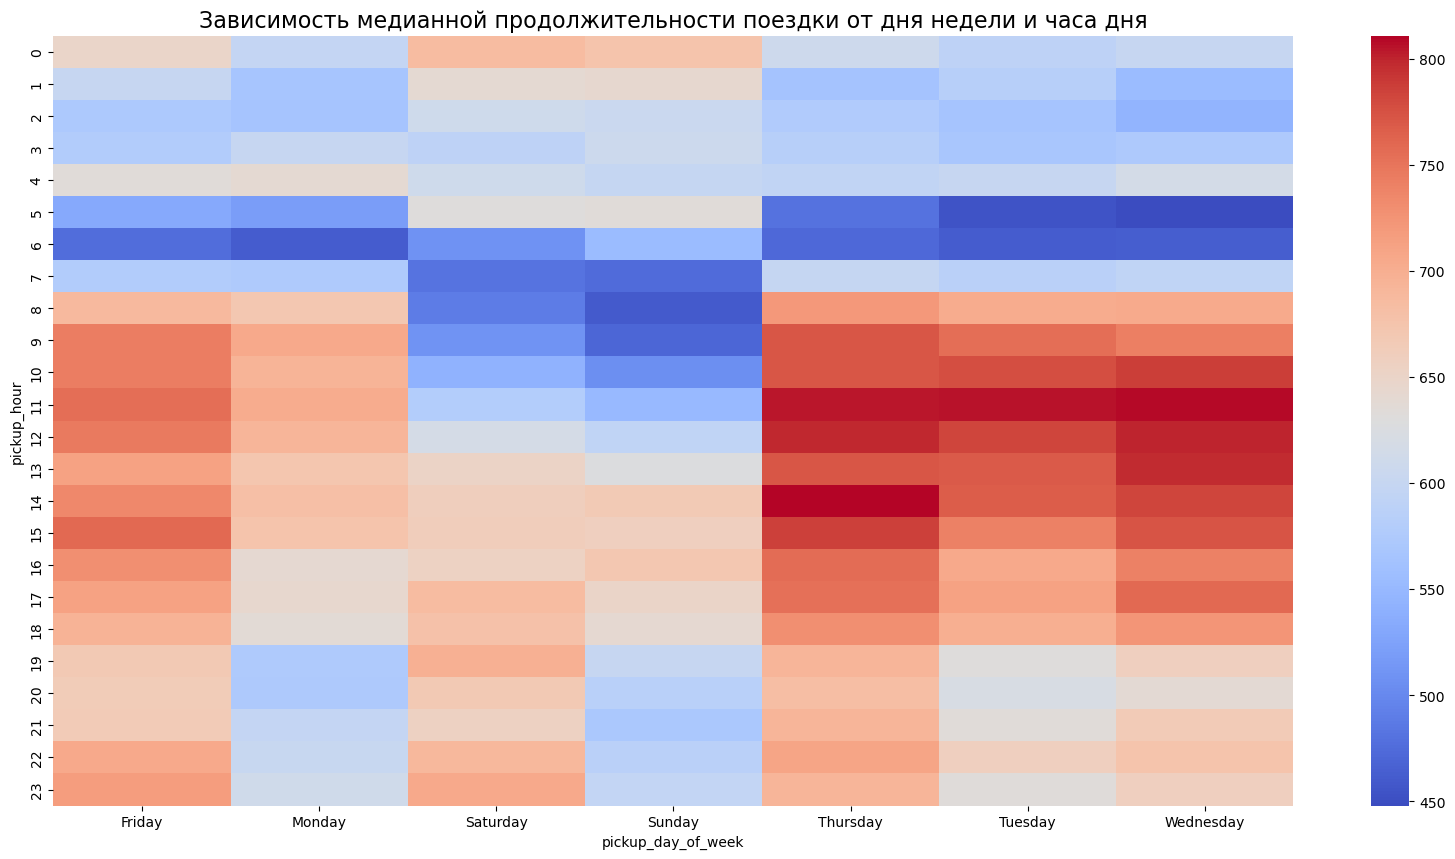

In [38]:
f, ax = plt.subplots(figsize=(20, 10))
trip_time=sns.heatmap(data=trip,
            cmap="coolwarm");
trip_time.set_title('Зависимость медианной продолжительности поездки от дня недели и часа дня', fontsize=16);

### Задание 3.7.
Постройте две диаграммы рассеяния (scatter-диаграммы):
* первая должна иллюстрировать географическое расположение точек начала поездок (pickup_longitude, pickup_latitude)
* вторая должна географическое расположение точек завершения поездок (dropoff_longitude, dropoff_latitude).

Для этого на диаграммах по оси абсцисс отложите широту (longitude), а по оси ординат - долготу (latitude).
Включите в визуализацию только те точки, которые находятся в пределах Нью-Йорка - добавьте следующие ограничения на границы осей абсцисс и ординат:

city_long_border = (-74.03, -73.75)

city_lat_border = (40.63, 40.85)

Добавьте на диаграммы расцветку по десяти географическим кластерам (geo_cluster), которые мы сгенерировали ранее.

**Рекомендация:** для наглядности уменьшите размер точек на диаграмме рассеяния.  


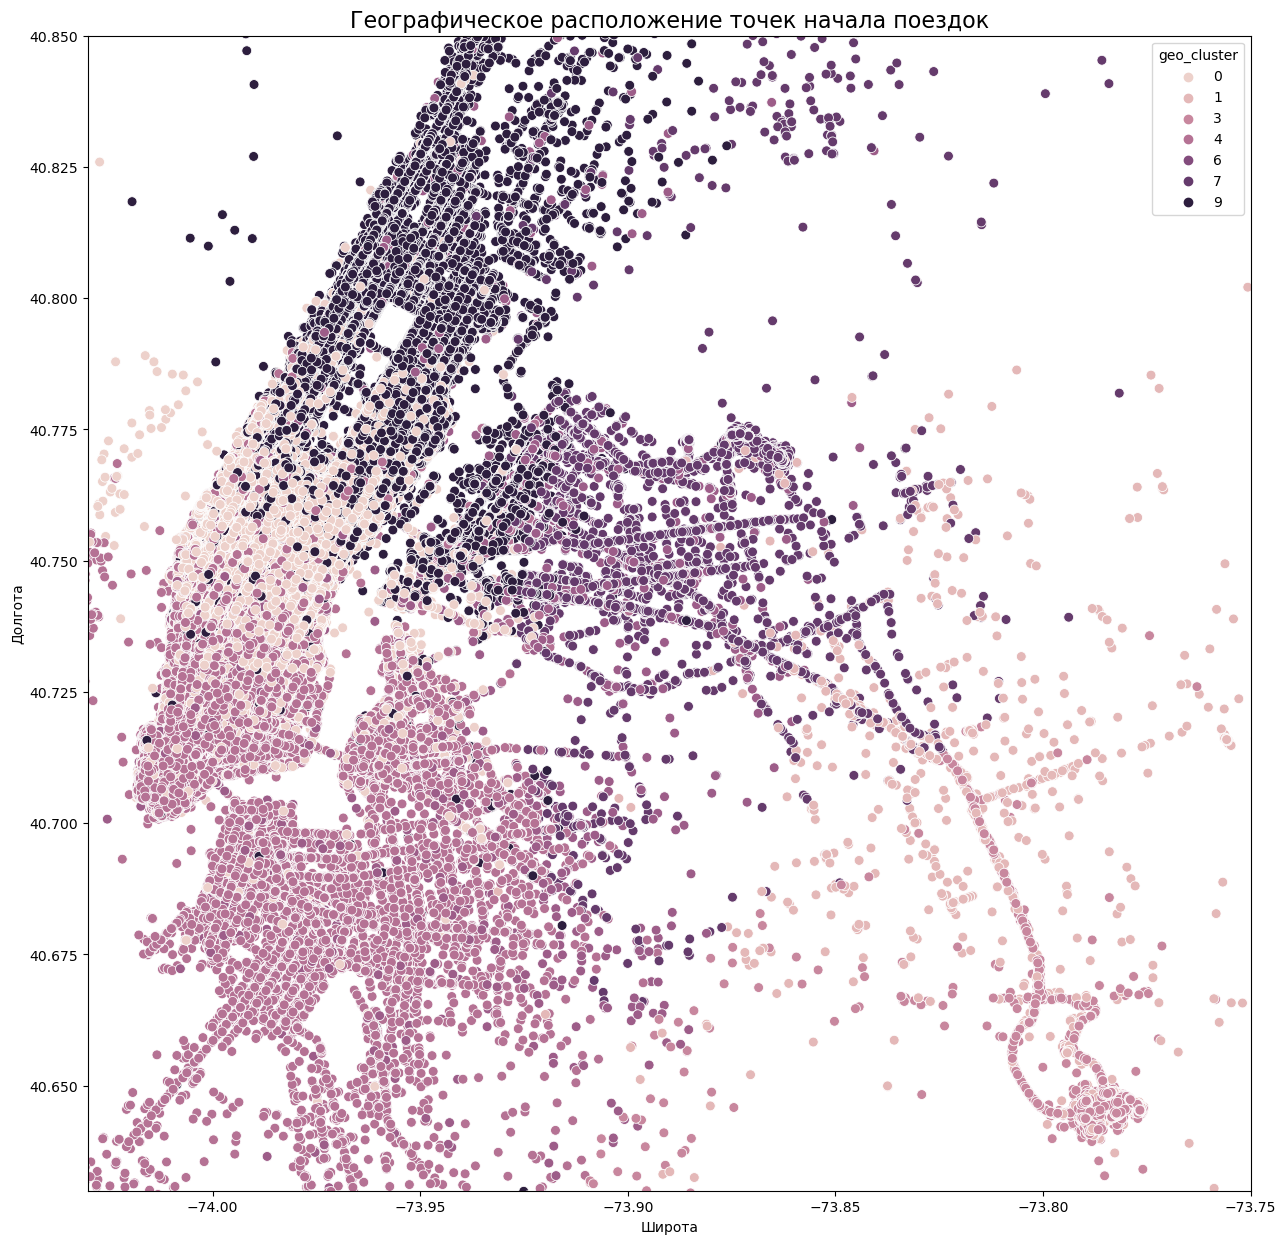

In [39]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)


fig = plt.figure(figsize=(15, 15))
scatterplot1 = sns.scatterplot(
    data=taxi_fill,
    x='pickup_longitude',
    y='pickup_latitude',
    hue='geo_cluster',
    s=50
);
scatterplot1.set(xlim=city_long_border, ylim=city_lat_border);
scatterplot1.set_title('Географическое расположение точек начала поездок', fontsize=16);
scatterplot1.set_xlabel('Широта');
scatterplot1.set_ylabel('Долгота');

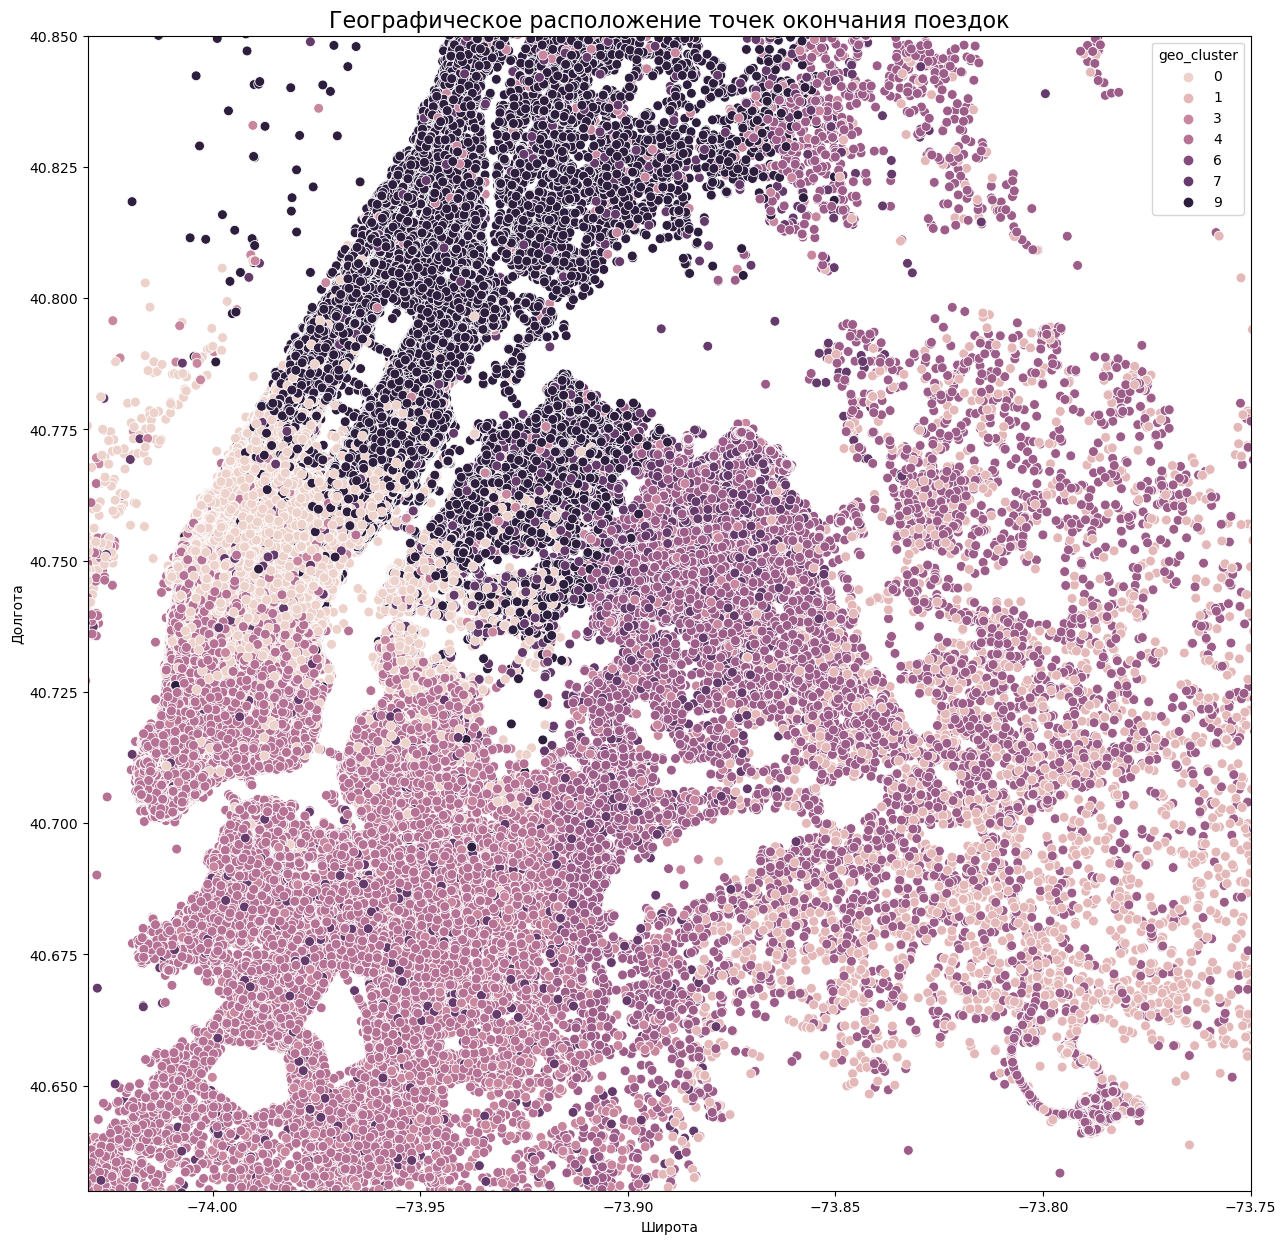

In [40]:
fig = plt.figure(figsize=(15, 15))
scatterplot2 = sns.scatterplot(
    data=taxi_fill,
    x='dropoff_longitude',
    y='dropoff_latitude',
    hue='geo_cluster',
    s=50
);
scatterplot2.set(xlim=city_long_border, ylim=city_lat_border);
scatterplot2.set_title('Географическое расположение точек окончания поездок', fontsize=16);
scatterplot2.set_xlabel('Широта');
scatterplot2.set_ylabel('Долгота');

## 4. Отбор и преобразование признаков

Перед тем как перейти к построению модели, осталось сделать ещё несколько шагов.
* Следует помнить, что многие алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. Поэтому нам необходимо их закодировать;
* Надо отобрать признаки, которые мы будем использовать для обучения модели;
*  Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить сходимость моделей, в основе которых лежат численные методы.


In [41]:
print('Shape of data: {}'.format(taxi_fill.shape))
print('Columns: {}'.format(taxi_fill.columns))

Shape of data: (1458233, 27)
Columns: Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_date', 'pickup_hour', 'pickup_day_of_week',
       'pickup_holiday', 'total_distance', 'total_travel_time',
       'number_of_steps', 'haversine_distance', 'direction', 'geo_cluster',
       'temperature', 'visibility', 'wind speed', 'precip', 'events',
       'trip_duration_log'],
      dtype='object')


Для удобства работы сделаем копию исходной таблицы с поездками:

In [42]:
train_data = taxi_fill.copy()
train_data.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  ...  number_of_steps  \
0         40.765602                  N  ...              5.0   
1         40.731152                  N  ...              6.0   
2         40.710087                  N  ...             16.0   
3         40.706718                  N  ...              4.0   
4         40.782520                  N  ...              5.0   

  haversine_distance   direction geo_cluster temperature  visibility  \
0           1.498521   99.970196           9         4.4         8.0   
1           1.805507 -117.153768           4        28.9        16.1   
2           6.385098 -159.680165           4        -6.7        16.1   
3           1.485498 -172.737700           4         7.2        16.1   
4           1.188588  179.473585           9         9.4        16.1   

   wind speed  precip  events  trip_duration_log  
0        27.8     0.3    None           6.122493  
1         7.4     0.0    None           6.498282  
2        24.1     0.0    None           7.661527  
3        25.9     0.0    None           6.063785  
4         9.3     0.0    None           6.077642  

[5 rows x 27 columns]

### Задание 4.1.
Сразу позаботимся об очевидных неинформативных и избыточных признаках.

а) Какой из признаков является уникальным для каждой поездки и не несет полезной информации в определении ее продолжительности?

б) Утечка данных (data leak) - это…

в) Подумайте, наличие какого из признаков в обучающем наборе данных создает утечку данных?

г) Исключите выбранные в пунктах а) и в) признаки из исходной таблицы с данными. Сколько столбцов в таблице у вас осталось?


In [43]:
train_data.nunique()

id                    1458233
vendor_id                   2
pickup_datetime       1379849
dropoff_datetime      1379993
passenger_count            10
pickup_longitude        23014
pickup_latitude         45219
dropoff_longitude       33801
dropoff_latitude        62503
store_and_fwd_flag          2
trip_duration            7413
pickup_date               182
pickup_hour                24
pickup_day_of_week          7
pickup_holiday              2
total_distance         197214
total_travel_time       19438
number_of_steps            43
haversine_distance    1451907
direction             1451647
geo_cluster                10
temperature               124
visibility                 17
wind speed                 22
precip                     28
events                      4
trip_duration_log        7413
dtype: int64

In [44]:
train_data.shape

(1458233, 27)

Уникальным для каждой поездки является признак id

Утечка данных - ситуация, в которой данные используемые для обучения модели, содержат прямую или косвенную информацию о целевой переменной, но эти данные недоступны в реальных условиях.

Утечку данных создает признак dropoff_datetime

Ранее мы извлекли всю необходимую для нас информацию из даты начала поездки, теперь мы можем избавиться от этих признаков, так как они нам больше не понадобятся:


In [45]:
drop_columns = ['pickup_datetime', 'pickup_date','id','dropoff_datetime']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data:  {}'.format(train_data.shape))

Shape of data:  (1458233, 23)


### Задание 4.2.
Закодируйте признак vendor_id в таблице train_data таким образом, чтобы он был равен 1, если идентификатор таксопарка равен 0, и 1 в противном случае.

Закодируйте признак store_and_fwd_flag в таблице train_data таким образом, чтобы он был равен 0, если флаг выставлен в значение "N", и 0 в противном случае.

а) Рассчитайте среднее по закодированному столбцу vendor_id. Ответ приведите с точностью до сотых.

б) Рассчитайте среднее по закодированному столбцу store_and_fwd_flag. Ответ приведите с точностью до тысячных.



In [46]:
train_data['vendor_id'] = train_data['vendor_id'].astype(str)
train_data["vendor_id"] = np.where(train_data["vendor_id"].str.contains('1'), 0, 1)
print(f'Среднее по закодированному столбцу vendor_id: {round(train_data["vendor_id"].mean(),2)}')

train_data["store_and_fwd_flag"] = np.where(train_data["store_and_fwd_flag"].str.contains('N'), 0, 1)
print(f'Среднее по закодированному столбцу store_and_fwd_flag: {round(train_data["store_and_fwd_flag"].mean(),3)}')

Среднее по закодированному столбцу vendor_id: 0.53
Среднее по закодированному столбцу store_and_fwd_flag: 0.006


### Задание 4.3.
Создайте таблицу data_onehot из закодированных однократным кодированием признаков pickup_day_of_week, geo_cluster и events в таблице train_data с помощью OneHotEndoder из библиотеки sklearn. Параметр drop выставите в значение 'first', чтобы удалять первый бинарный столбец, тем самым не создавая излишних признаков.

В результате работы OneHotEncoder вы получите безымянный numpy-массив, который нам будет необходимо преобразовать обратно в DataFrame, для более удобной работы в дальнейшем. Чтобы получить имена закодированных столбцов у объекта типа OneHotEncoder есть специальный метод get_feature_names_out(). Он возвращает список новых закодированных имен столбцов в формате <оригинальное имя столбца>_<имя категории>.


В этом псевдокоде:
* one_hot_encoder - объект класса OneHotEncoder
* data_onehot - numpy-массив, полученный в результате трансформации кодировщиком

В результате выполнения задания у вас должен быть образован DataFrame `data_onehot`, который содержит кодированные категориальные признаки pickup_day_of_week, geo_cluster и events.


Сколько бинарных столбцов у вас получилось сгенерировать с помощью однократного кодирования?


In [47]:
columns_to_change = ['pickup_day_of_week', 'geo_cluster', 'events']
encoder = OneHotEncoder(drop='first')
data_onehot = encoder.fit_transform(train_data[['pickup_day_of_week', 'geo_cluster', 'events']]).toarray()
column_names = encoder.get_feature_names_out(columns_to_change)
data_onehot = pd.DataFrame(data_onehot, columns=column_names)
print(f'Получилось сгенерировать с помощью однократного кодирования {len(data_onehot.axes[1])} бинарных столбцов')

Получилось сгенерировать с помощью однократного кодирования 18 бинарных столбцов


Добавим полученную таблицу с закодированными признаками:

In [48]:
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(columns_to_change, axis=1), data_onehot],
    axis=1
)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 38)


Теперь, когда категориальные признаки предобработаны, сформируем матрицу наблюдений X, вектор целевой переменной y и его логарифм y_log. В матрицу наблюдений войдут все столбцы из таблицы с поездками за исключением целевого признака trip_duration и его логарифмированной версии trip_duration_log:


In [49]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

Все наши модели мы будем обучать на логарифмированной версии y_log.

Выбранный тип валидации - hold-out. Разобьем выборку на обучающую и валидационную в соотношении 67/33:

In [50]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log,
    test_size=0.33,
    random_state=42
)

На данный момент у нас достаточно много признаков: скорее всего, не все из них будут важны. Давайте оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.


### Задание 4.4.
С помощью SelectKBest отберите 25 признаков, наилучшим образом подходящих для предсказания целевой переменной в логарифмическом масштабе. Отбор реализуйте по обучающей выборке, используя параметр score_func = f_regression.

Укажите признаки, которые вошли в список отобранных


In [51]:
selector = SelectKBest(f_regression, k=25)
selector.fit(X_train, y_train_log)

best_features = selector.get_feature_names_out()
X_train = X_train[best_features]
X_valid = X_valid[best_features]
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 977016 entries, 293850 to 121958
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   vendor_id                     977016 non-null  int64  
 1   passenger_count               977016 non-null  int64  
 2   pickup_longitude              977016 non-null  float64
 3   pickup_latitude               977016 non-null  float64
 4   dropoff_longitude             977016 non-null  float64
 5   dropoff_latitude              977016 non-null  float64
 6   store_and_fwd_flag            977016 non-null  int64  
 7   pickup_hour                   977016 non-null  int64  
 8   pickup_holiday                977016 non-null  object 
 9   total_distance                977016 non-null  float64
 10  total_travel_time             977016 non-null  float64
 11  number_of_steps               977016 non-null  float64
 12  haversine_distance            977016 no

Так как мы будем использовать различные модели, в том числе внутри которых заложены численные методы оптимизации, то давайте заранее позаботимся о масштабировании факторов.


### Задание 4.5.
Нормализуйте предикторы в обучающей и валидационной выборках с помощью MinMaxScaler из библиотеки sklearn. Помните, что обучение нормализатора производится на обучающей выборке, а трансформация на обучающей и валидационной!

Рассчитайте среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из валидационной выборки. Ответ округлите до сотых.


In [52]:
scaler = preprocessing.MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [53]:
print(f'Cреднее арифметическое из валидационной выборки: {round(X_valid_scaled.mean(), 2)}')
print(f'Cреднее арифметическое для первого предиктора из валидационной выборки: {X_valid_scaled[:,0].mean().round(2)}')

Cреднее арифметическое из валидационной выборки: 0.26
Cреднее арифметическое для первого предиктора из валидационной выборки: 0.54


## 5. Решение задачи регрессии: линейная регрессия и деревья решений

Определим метрику, по которой мы будем измерять качество наших моделей. Мы будем следовать канонам исходного соревнования на Kaggle и в качестве метрики использовать RMSLE (Root Mean Squared Log Error), которая вычисляется как:
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$
где:
* $y_i$ - истинная длительность i-ой поездки на такси (trip_duration)
* $\hat{y_i}$- предсказанная моделью длительность i-ой поездки на такси

Заметим, что логарифмирование целевого признака мы уже провели заранее, поэтому нам будет достаточно вычислить метрику RMSE для модели, обученной прогнозировать длительность поездки такси в логарифмическом масштабе:
$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$



### Задание 5.1.
Постройте модель линейной регрессии на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [54]:
lr = linear_model.LinearRegression()
lr.fit(X_train_scaled, y_train_log)
y_train_log_pred = lr.predict(X_train_scaled)
y_valid_log_pred = lr.predict(X_valid_scaled)
print('RMSLE метрика в Train выборке: {:.2f}'.format(np.sqrt(mean_squared_error(y_train_log, y_train_log_pred))))
print('RMSLE метрика в Valid выборке: {:.2f}'.format(np.sqrt(mean_squared_error(y_valid_log, y_valid_log_pred))))

RMSLE метрика в Train выборке: 0.54
RMSLE метрика в Valid выборке: 0.54


### Задание 5.2.
Сгенерируйте полиномиальные признаки 2-ой степени с помощью PolynomialFeatures из библиотеки sklearn. Параметр include_bias выставите в значение False.

Постройте модель полиномиальной регрессии 2-ой степени на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [55]:
poly = PolynomialFeatures(2,include_bias=False)
X_train_scaled_poly = poly.fit_transform(X_train_scaled)
X_valid_scaled_poly = poly.transform(X_valid_scaled)
lr = linear_model.LinearRegression()
lr.fit(X_train_scaled_poly, y_train_log)
y_train_log_pred = lr.predict(X_train_scaled_poly)
y_valid_log_pred = lr.predict(X_valid_scaled_poly)
print('RMSLE метрика в Train выборке: {:.2f}'.format(np.sqrt(mean_squared_error(y_train_log, y_train_log_pred))))
print('RMSLE метрика в Valid выборке: {:.2f}'.format(np.sqrt(mean_squared_error(y_valid_log, y_valid_log_pred))))

RMSLE метрика в Train выборке: 0.47
RMSLE метрика в Valid выборке: 0.70


### Задание 5.3.
Постройте модель полиномиальной регрессии 2-ой степени с L2-регуляризацией (регуляризация по Тихонову) на обучающей выборке  (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Коэффициент регуляризации $\alpha установите равным 1, остальные параметры оставьте по умолчанию.

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [56]:
ridge = linear_model.Ridge()
ridge.fit(X_train_scaled_poly, y_train_log)
y_train_log_pred = ridge.predict(X_train_scaled_poly)
y_valid_log_pred = ridge.predict(X_valid_scaled_poly)
print('RMSLE метрика в Train выборке: {:.2f}'.format(np.sqrt(mean_squared_error(y_train_log, y_train_log_pred))))
print('RMSLE метрика в Valid выборке: {:.2f}'.format(np.sqrt(mean_squared_error(y_valid_log, y_valid_log_pred))))

RMSLE метрика в Train выборке: 0.48
RMSLE метрика в Valid выборке: 0.48


### Задание 5.4.
Постройте модель дерева решений (DecisionTreeRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). Все параметры оставьте по умолчанию.

а) Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.

б) Наблюдаются ли у вашей модели признаки переобучения?


In [57]:

dt = tree.DecisionTreeRegressor()
dt.fit(X_train_scaled, y_train_log)
y_train_log_pred = dt.predict(X_train_scaled)
y_valid_log_pred = dt.predict(X_valid_scaled)
print('метрика RMSLE на тренировочной выборке: {:.2f}'.format(np.sqrt(mean_squared_error(y_train_log, y_train_log_pred))))
print('метрика RMSLE на валидационной выборке: {:.2f}'.format(np.sqrt(mean_squared_error(y_valid_log, y_valid_log_pred))))

метрика RMSLE на тренировочной выборке: 0.00
метрика RMSLE на валидационной выборке: 0.56


### Задание 5.5.
Переберите все возможные варианты глубины дерева решений в диапазоне от 7 до 20:

max_depths = range(7, 20)

Постройте линейные графики изменения метрики RMSE на тренировочной и валидационной выборках в зависимости от значения параметра глубины дерева решений.

а) Найдите оптимальное значение максимальной глубины дерева, для которой будет наблюдаться минимальное значение RMSLE на обучающей выборке, но при этом еще не будет наблюдаться переобучение (валидационная кривая еще не начинает возрастать).

б) Чему равно значение метрик RMSLE на тренировочной и валидационной выборках для дерева решений с выбранной оптимальной глубиной? Ответ округлите до сотых.


In [58]:
param_grid = {'max_depth': range(7, 20)}
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    n_jobs = -1
)
grid_search.fit(X_train_scaled, y_train_log)
print("Оптимальная глубина дерева решений: {}".format(grid_search.best_params_))

Оптимальная глубина дерева решений: {'max_depth': 11}


In [59]:
dt = tree.DecisionTreeRegressor(max_depth = 12)
dt.fit(X_train_scaled, y_train_log)
y_train_log_pred = dt.predict(X_train_scaled)
y_valid_log_pred = dt.predict(X_valid_scaled)
print('метрика RMSLE на тренировочной выборке: {:.2f}'.format(np.sqrt(mean_squared_error(y_train_log, y_train_log_pred))))
print('метрика RMSLE на валидационной выборке: {:.2f}'.format(np.sqrt(mean_squared_error(y_valid_log, y_valid_log_pred))))

метрика RMSLE на тренировочной выборке: 0.41
метрика RMSLE на валидационной выборке: 0.43


## 6. Решение задачи регрессии: ансамблевые методы и построение прогноза

Переходим к тяжелой артиллерии: ансамблевым алгоритмам.

### Задание 6.2.
Постройте модель градиентного бустинга над деревьями решений (GradientBoostingRegressor) на обучающей выборке (факторы должны быть нормализованы, целевую переменную используйте в логарифмическом масштабе). В качестве гиперпараметров укажите следующие:
* learning_rate=0.5,
* n_estimators=100,
* max_depth=6,
* min_samples_split=30,
* random_state=42

Для полученной модели рассчитайте метрику RMSLE на тренировочной и валидационной выборках. Ответ округлите до сотых.


In [61]:
gbr = GradientBoostingRegressor(learning_rate=0.5,
                                n_estimators=100,
                                max_depth=6,
                                min_samples_split=30,
                                random_state=42)
gbr.fit(X_train_scaled, y_train_log)
y_train_log_pred = gbr.predict(X_train_scaled)
y_valid_log_pred = gbr.predict(X_valid_scaled)
print('метрика RMSLE на тренировочной выборке для модели градиентного бустинга: {:.2f}'.format(np.sqrt(mean_squared_error(y_train_log, y_train_log_pred))))
print('метрика RMSLE на валидационной выборке для модели градиентного бустинга: {:.2f}'.format(np.sqrt(mean_squared_error(y_valid_log, y_valid_log_pred))))

метрика RMSLE на тренировочной выборке для модели градиентного бустинга: 0.37
метрика RMSLE на валидационной выборке для модели градиентного бустинга: 0.39


### Задание 6.3.
Какая из построенных вами моделей показала наилучший результат (наименьшее значение RMSLE на валидационной выборке)?
* Линейная регрессия
* Полиномиальная регрессия 2ой степени
* Дерево решений
* Случайный лес
* Градиентный бустинг над деревьями решений


Градиентный бустинг  the BEST

### Задание 6.4.
Постройте столбчатую диаграмму коэффициентов значимости каждого из факторов.

Укажите топ-3 наиболее значимых для предсказания целевого признака - длительности поездки в логарифмическом масштабе - факторов.


In [62]:
coef = gbr.feature_importances_
data = pd.DataFrame([coef], columns=best_features)
data

vendor_id  passenger_count  pickup_longitude  pickup_latitude  \
0   0.003932         0.000832          0.012093         0.011681   

   dropoff_longitude  dropoff_latitude  store_and_fwd_flag  pickup_hour  \
0           0.013027          0.029107            0.000029     0.057439   

   pickup_holiday  total_distance  ...  pickup_day_of_week_Saturday  \
0        0.001469        0.628181  ...                     0.007542   

   pickup_day_of_week_Sunday  pickup_day_of_week_Thursday  \
0                   0.007148                     0.000326   

   pickup_day_of_week_Tuesday  pickup_day_of_week_Wednesday  geo_cluster_1  \
0                    0.000714                        0.0006        0.00053   

   geo_cluster_3  geo_cluster_5  geo_cluster_7  geo_cluster_9  
0       0.000067       0.000194       0.000192       0.000411  

[1 rows x 25 columns]

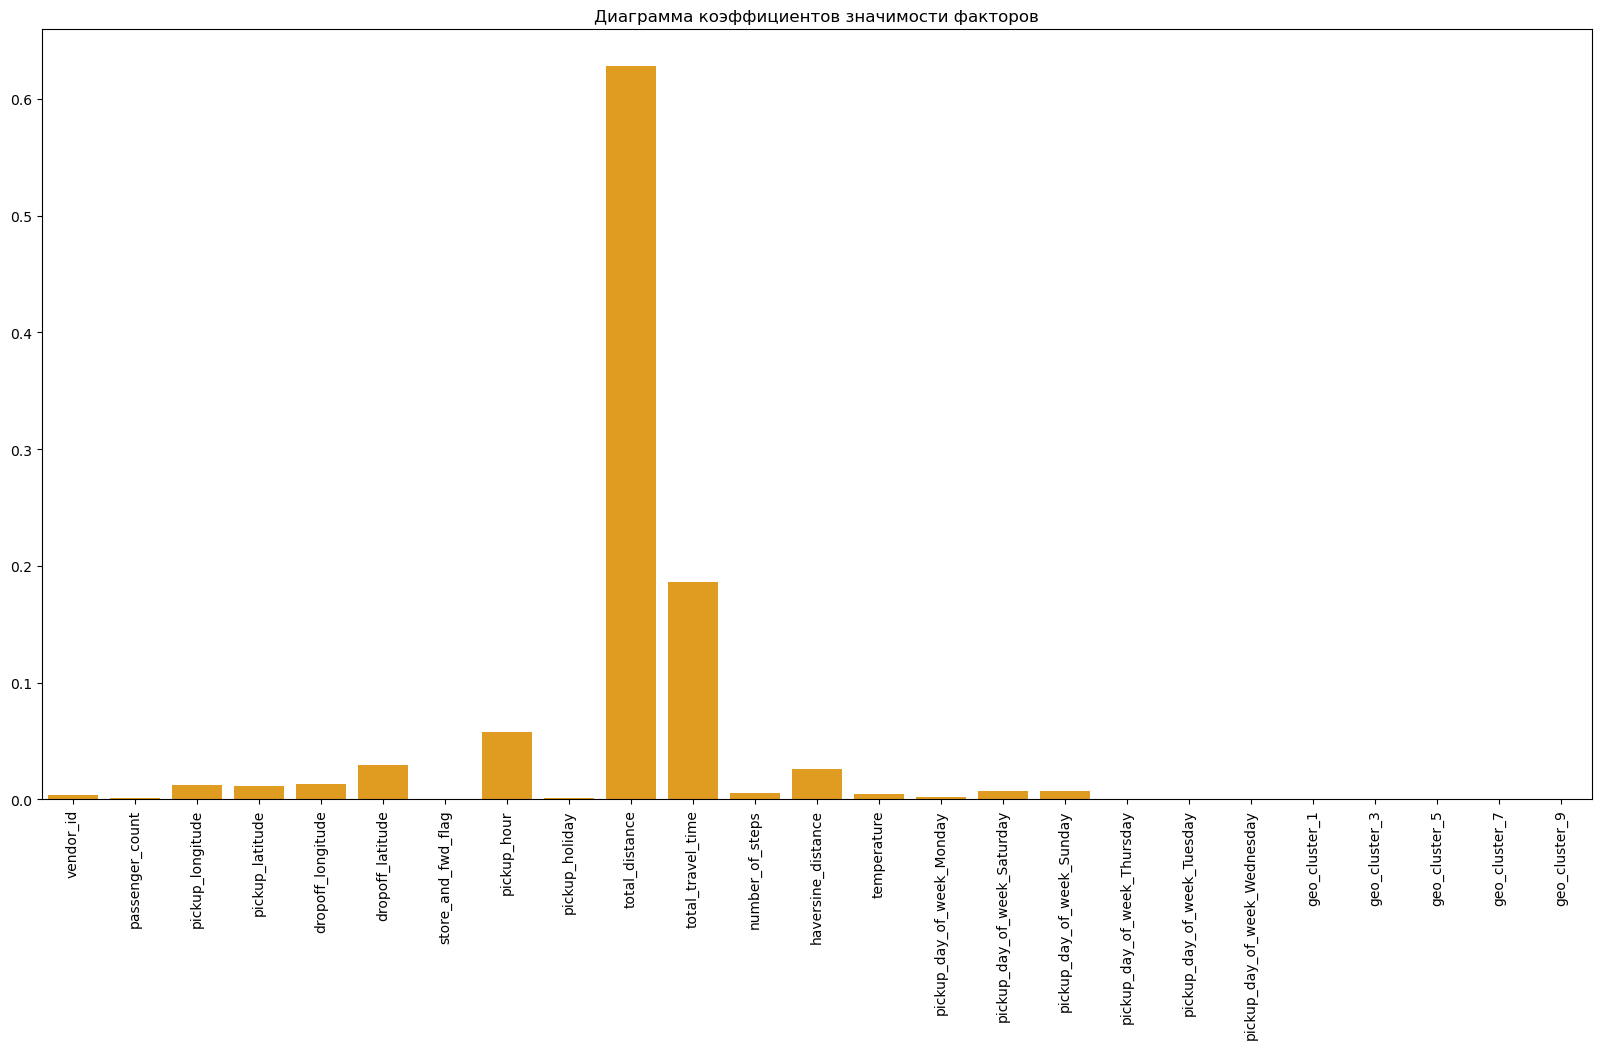

In [63]:
fig = plt.figure(figsize=(20, 10))
barplot = sns.barplot(
    data=data,color="orange")
barplot.set_title('Диаграмма коэффициентов значимости факторов')
barplot.set_xticklabels(barplot.get_xticklabels(),rotation = 90);

### Задание 6.5.
Для лучшей из построенных моделей рассчитайте медианную абсолютную ошибку (MeAE - в sklearn функция median_absolute_error) предсказания длительности поездки такси на валидационной выборке:
$$ MeAE = median(|y_i-\hat{y_i}|)$$

Значение метрики MeAE переведите в минуты и округлите до десятых.


In [64]:
y_norm = np.exp(y_valid_log)-1
y_norm_pred = np.exp(y_valid_log_pred)-1
from sklearn.metrics import median_absolute_error
MeAE = median_absolute_error(y_norm, y_norm_pred)/60
print(f'медианная абсолютную ошибку предсказания длительности поездки такси на валидационной выборке: {round(MeAE, 1)}')

медианная абсолютную ошибку предсказания длительности поездки такси на валидационной выборке: 1.8


Финальный шаг - сделать submit -  предсказание для отложенного тестового набора данных.

Прочитаем тестовые данные и заранее выделим столбец с идентификаторами поездок из тестового набора данных. Он нам еще пригодится:


In [79]:
test_data = pd.read_csv("/kaggle/input/new-test/Project5_test_data.csv")
osrm_data_test = pd.read_csv("/kaggle/input/new-test/Project5_osrm_data_test.csv")
test_id = test_data['id']

Перед созданием прогноза для тестовой выборки необходимо произвести все манипуляции с данными, которые мы производили с тренировочной выборкой, а именно:
* Перевести признак pickup_datetime в формат datetime;
* Добавить новые признаки (временные, географические, погодные и другие факторы);
* Произвести очистку данных от пропусков;
* Произвести кодировку категориальных признаков:
    * Закодировать бинарные признаки;
    * Закодировать номинальные признаки с помощью обученного на тренировочной выборке OneHotEncoder’а;
* Сформировать матрицу наблюдений, оставив в таблице только те признаки, которые были отобраны с помощью SelectKBest;
* Нормализовать данные с помощью обученного на тренировочной выборке MinMaxScaler’а.


In [80]:
test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)
test_data = add_cluster_features(test_data)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data (test_data)
one_hot_encoder = OneHotEncoder(drop='first')
test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[columns_to_change]).toarray()
column_names = one_hot_encoder.get_feature_names_out(columns_to_change)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)
test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(columns_to_change, axis=1), test_data_onehot],
    axis=1
)

Только после выполнения всех этих шагов можно сделать предсказание длительности поездки для тестовой выборки. Не забудьте перевести предсказания из логарифмического масштаба в истинный, используя формулу:
$$y_i=exp(z_i)-1$$

После того, как вы сформируете предсказание длительности поездок на тестовой выборке вам необходимо будет создать submission-файл в формате csv, отправить его на платформу Kaggle и посмотреть на результирующее значение метрики RMSLE на тестовой выборке.

Код для создания submission-файла:


In [81]:
X_test = test_data[best_features]
X_test_scaled = scaler.transform(X_test)
print('Shape of data: {}'.format(X_test.shape))

Shape of data: (625134, 25)


In [82]:
y_test_log_pred = gbr.predict(X_test_scaled)
y_test_predict = np.exp(y_test_log_pred)-1

submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('/kaggle/working/submission_gb.csv', index=False)

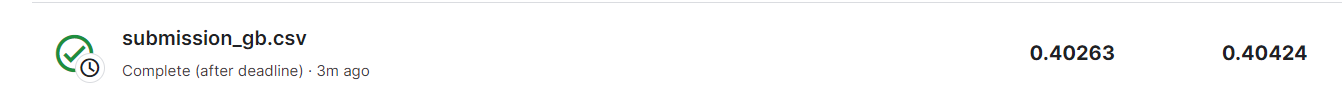